# Bioassay Report Generator

This **jupyter notebook** should be run within a **virtual environment, Python2 (w2p27)**.

Here's how to open the notebook from the terminal:

````
aubrey@aubrey-Latitude-7280:~/fix-bioassay-db$ workon w2p27
(w2p27) aubrey@aubrey-Latitude-7280:~/fix-bioassay-db$ jupyter notebook
````

# Imports

In [1]:
#%matplotlib inline
import pandas as pd
import sqlite3
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy.stats as ss
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
import subprocess
import re
import os.path

import lifelines
from lifelines import KaplanMeierFitter, statistics

#pd.options.display.max_rows = 8

# Utility Functions

In [2]:
def tex_escape(text):
    """
        :param text: a plain text message
        :return: the message escaped to appear correctly in LaTeX
    """
    conv = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '\\': r'\textbackslash{}',
        '<': r'\textless{}',
        '>': r'\textgreater{}',
    }
    regex = re.compile('|'.join(re.escape(unicode(key)) for key in sorted(conv.keys(), key = lambda item: - len(item))))
    return regex.sub(lambda match: conv[match.group()], text)

# Database

In [3]:
dbpath = 'databases/storage.sqlite'
conn = sqlite3.connect(dbpath)

In [4]:
def check_btl_date_died():
    """
    Finds records in the btl table where date_died does not agree with date recorded in the obs table.
    The df generated by this SQL should be empty    
    """

    sql = """
    SELECT btl.id, obs.notes, obs.date_observed, btl.date_died
    FROM btl, obs
    WHERE btl.id = obs.btl
        AND obs.notes LIKE '%dead%'
        AND ((btl.date_died != obs.date_observed) OR (btl.date_died IS NULL) OR (btl.date_died = ''))
    GROUP BY btl.id
    ORDER BY btl.id;
    """
    df = pd.read_sql_query(sql, conn)
    
    # Fix the problems
    
    for i, r in df.iterrows():
        sql = 'UPDATE btl SET date_died="{}" WHERE id={};'.format(r.date_observed, r.id)   
        print(sql)
        cur = conn.cursor()
        cur.execute(sql)
        conn.commit()    
    return df # df prior to fixing problems

#check_btl_date_died()

# List Bioassays

In [5]:
sql ="""
SELECT
    bioassay_name
FROM
    btl
GROUP BY bioassay_name
ORDER BY bioassay_name
"""
df = pd.read_sql_query(sql, conn)
pd.options.display.max_rows = 1000
df

,bioassay_name
0,None
1,DUG42-1
2,DUG42-2
3,MALB-1
4,MALB-2
5,MALBperOS-1
6,PNG-1
7,PNG-2
8,PNG-3
9,PNG-4


# Parameters

In [6]:
# Bioassay_name must be assigned a value from the data frame above.
# To generate a report which includes all replicates in a bioassay use a wild card, example: DUG42-%

#bioassay_name = 'DUG42-%' #OK
#bioassay_name = 'MALB-%' #OK
#bioassay_name = 'MALBperOS-%' # OK
#bioassay_name = 'PNG-%' #OK
#bioassay_name = 'PNGperOS-%' #OK
#bioassay_name = 'V23B-%' #OK
#bioassay_name = 'V23B_large_bioassay-%' # OK
#bioassay_name = 'V23B_perOSIN-%' # OK
#bioassay_name = 'V23BperOS-%' # OK



# Summary Section

In [7]:
def change_bioassay_name(old_name, new_name):
    sql = 'UPDATE bioassay SET name="{}" WHERE name="{}";'.format(new_name, old_name)   
    print(sql)
    cur = conn.cursor()
    cur.execute(sql)
    conn.commit() 
    return

#change_bioassay_name('Mal B perOSI-1', 'MALBperOS')

In [8]:
def summary_section_tex():
    
    sql = """
    SELECT
        *
    FROM
        bioassay;
    """.format(title)
    df = pd.read_sql_query(sql, conn)

    s = bioassay_name.split('-')[0]
    try:
        summary = df[df.name==s].tex.values[0]
    except:
        summary = 'Summary not available for "{}"'.format(s)
        summary = tex_escape(summary)
    #print(summary)

    sql = """SELECT bioassay_name, date_start_bioassay, date_end_bioassay, bioassay_treatment, count(*) AS N
    FROM btl 
    WHERE bioassay_name like '{}%'
    GROUP BY bioassay_name, date_start_bioassay, date_end_bioassay, bioassay_treatment
    ORDER BY bioassay_name, date_start_bioassay, date_end_bioassay, bioassay_treatment;
    """.format(bioassay_name)
    df = pd.read_sql_query(sql, conn)
    pd.options.display.max_rows = 100
    bioassay_summary_table_tex = df.to_latex()
    df

    tex = r'''
    \clearpage
    \section{Summary}

    \begin{table}[h!]
        \centering
        \caption{Bioassay summary.}
        ---bioassay_summary_table_tex---
    \end{table}

    ---summary---
    '''

    tex = tex.replace('---summary---', summary)
    tex = tex.replace('---bioassay_summary_table_tex---', bioassay_summary_table_tex)
    return tex

#print(summary_section_tex())

# Mass Section

In [9]:
def change_in_mass_section_tex():
    sql ="""
        SELECT 
            date_observed,
            date_start_bioassay,
            bioassay_treatment,
            julianday(date_observed) - julianday(date_start_bioassay) AS days,
            btl, mass
        FROM btl, obs
        WHERE
            btl.id = obs.btl
        AND
            bioassay_name LIKE '{}'
        AND mass IS NOT NULL
        ORDER BY btl, date_observed;
    """.format(bioassay_name)
    df = pd.read_sql_query(sql, conn)
    pd.options.display.max_rows = 8
    df

    df['change_in_mass_per_day'] = df['mass'].diff()/df['days']
    df = df[df.days>0]
    pd.options.display.max_rows = 8
    df

    # Remove outliers

    percentile1 = df["change_in_mass_per_day"].quantile(0.01)
    percentile99 = df["change_in_mass_per_day"].quantile(0.99)
    original_row_count = df.shape[0]
    df = df[df.change_in_mass_per_day.between(percentile1, percentile99)]
    final_row_count = df.shape[0]
    print('Removing outliers from the change_in_mass_per_day column')
    print('Original row count: {}'.format(original_row_count))
    print('Final row count: {}'.format(final_row_count))
    print('Outliers removed: {}'.format(original_row_count - final_row_count))

    plt.figure()
    bp = sns.boxplot(x="bioassay_treatment", y="change_in_mass_per_day", data=df)
    bp.figure.savefig('bp.pdf')

    control = df[df.bioassay_treatment=='control'].change_in_mass_per_day.values
    virus = df[df.bioassay_treatment=='virus'].change_in_mass_per_day.values
    r = ss.kruskal(control, virus)
    r

    mass_pairwise_results = sp.posthoc_dunn(df, val_col='change_in_mass_per_day', group_col='bioassay_treatment', p_adjust = 'holm')

    mass_pairwise_results_tex = mass_pairwise_results.to_latex()
    #print(mass_pairwise_results_tex)

    tex = r'''
    \clearpage
    \section{Change in Mass}

    \begin{center}
         \includegraphics[width=\textwidth]{bp.pdf}
    \end{center}

    \begin{table}[h!]
        \centering
        \caption{Results of pairwise significance tests for differences in change in mass.}
    ---mass pairwise results---
    \end{table}
    '''
    # print(change_in_mass_section_tex)
    tex = tex.replace('---mass pairwise results---', mass_pairwise_results_tex)
    # print(change_in_mass_section_tex)
    return tex

#print(change_in_mass_section_tex())

# Tex preamble, titlepage and TOC

In [10]:
def preamble_tex():
    tex = r'''
    \documentclass[11pt]{scrartcl}
    \usepackage{textcomp}
    \usepackage{gensymb}
    \usepackage{graphicx}
    \usepackage{grffile} %required because there are multiple dot characters in my file names
    \usepackage{booktabs}
    \usepackage[letterpaper, margin=1in]{geometry}

    \usepackage[unicode=true,pdfusetitle,
    bookmarks=true,bookmarksnumbered=false,bookmarksopen=false,
    breaklinks=true,pdfborder={0 0 0},pdfborderstyle={},backref=false,colorlinks=true]
    {hyperref}
    \hypersetup{linkcolor=blue,citecolor=blue,urlcolor=blue}

    \titlehead{\centering\includegraphics[width=0.75in]{static/images/crb_logo.png}\\
    University of Guam Coconut Rhinoceros Beetle Biological Control Project\\
    Generated by bioassay-report-generator.ipynb ---notebook_version---\\
    \url{---github_repo---}}

    \title{Bioassay Report: ---title---}

    \author{Aubrey Moore and James J. Grasela\\University of Guam Coconut Rhinoceros Beetle Biocontrol Project}
    '''

    tex = tex.replace('---title---', title)
    tex = tex.replace('---notebook_version---', notebook_version)
    tex = tex.replace('---github_repo---', github_repo)
    return tex

#print(preamble_tex())

In [11]:
def titlepage_tex():
    tex = r'''
    \begin{titlepage}
        \maketitle
        \begin{center}
            \url{---outputfile_url---}
        \end{center}
        \tableofcontents
    \end{titlepage}
    '''
    tex = tex.replace('---outputfile_url---', outputfile_url)
    return tex

#print(titlepage_tex())

# Mortality Section

In [12]:
 def mortality_section_tex():
    sql = "SELECT * FROM btl WHERE bioassay_name LIKE '{}'".format(bioassay_name)
    df = pd.read_sql_query(sql, conn)    
    #print(df)

    t, e = lifelines.utils.datetimes_to_durations(
        start_times=pd.to_datetime(df.date_start_bioassay),
        end_times=pd.to_datetime(df.date_died),
        fill_date=pd.to_datetime(df.date_end_bioassay))
    df['t'] = t
    df['e'] = e

    # Create survorship plot
    plt.figure()
    fig, ax = plt.subplots(figsize=(18,6))
    kmf = KaplanMeierFitter()
    for name, grouped_df in df.groupby('bioassay_treatment'):
        kmf.fit(grouped_df['t'], grouped_df['e'], label=name)
        kmf.plot(ax=ax, linewidth=5, ci_show=False)
    ax.set_xlabel('days after treatment')
    ax.set_ylabel('proportion dead')
    ax.set_ylim([0,1])
    fig.savefig('survivorshipfig.pdf')

    # Create motality-table-tex
    results = statistics.pairwise_logrank_test(df['t'], df['bioassay_treatment'], df['e'])
    s = r'''
        \begin{table}[h!]
        \centering
        \caption{Pairwise differences among mortality curves.}
    '''
    s += results.summary.to_latex()
    s += '\end{table}'
    mortality_pairwise_table_tex = s
    #print(s)

    sql = """
    SELECT 
        bioassay_treatment, COUNT(*) AS ntotal
    FROM
        btl
    WHERE 
        bioassay_name LIKE '{}'
    GROUP BY bioassay_treatment
    ORDER BY bioassay_treatment;
    """.format(bioassay_name)    
    df_total = pd.read_sql_query(sql, conn)    
    df_total

    sql = """
    SELECT 
        bioassay_treatment, COUNT(*) AS ndead
    FROM
        btl
    WHERE 
        bioassay_name LIKE '{}'
    AND
        date_died IS NOT NULL
    GROUP BY bioassay_treatment
    ORDER BY bioassay_treatment;
    """.format(bioassay_name)    
    df_dead = pd.read_sql_query(sql, conn)    
    df_dead

    df = df_total.merge(df_dead, how='left').fillna(0)
    df

    def fisher(r, cdead, calive):
        return ss.fisher_exact([ [r.ntotal-r.ndead, r.ndead], [calive, cdead]])[1]

    # Treatment mortality is adjusted for control mortality
    # See http://www.ehabsoft.com/ldpline/onlinecontrol.htm

    df['mortality'] = df.ndead/df.ntotal
    control_mortality = df[df.bioassay_treatment=='control'].mortality.values[0]
    df['adjusted_mortality'] = (df.mortality-control_mortality)/(1-control_mortality)
    ctotal = df[df.bioassay_treatment=='control'].ntotal
    cdead = df[df.bioassay_treatment=='control'].ndead
    calive = ctotal-cdead
    df['significance'] = df.apply(fisher, axis=1, cdead=cdead, calive=calive)
    mortality_table_tex = df.to_latex()
    df

    tex = r'''
    \clearpage
    \section{Mortality}

    \begin{table}[h!]
        \centering
        \caption{Mortality summary.}
        ---mortality_table_tex---
    \end{table}

    \begin{center}
         \includegraphics[width=\textwidth]{survivorshipfig.pdf}
    \end{center}


    ---mortality_pairwise_table_tex--- 
    '''

    tex = tex.replace('---mortality_table_tex---', mortality_table_tex)
    tex = tex.replace('---mortality_pairwise_table_tex---', mortality_pairwise_table_tex)
    return tex
    
#print(mortality_section_tex())

# Post mortem images section

In [13]:
def get_postmortem_images(bioassay_name_pattern, image_limit):
    """
    """
    
    # get data
    
    sql = """
    SELECT id, bioassay_name, bioassay_treatment, pm_image
    FROM btl
    WHERE bioassay_name LIKE '{}' 
        AND pm_image IS NOT NULL AND pm_image != ''
    LIMIT {};
    """.format(bioassay_name_pattern, image_limit)
    df = pd.read_sql_query(sql, conn) 
    #rows = db.executesql(sql, as_dict=True)
    #df = pd.DataFrame(rows)
    df.dropna(inplace=True)
    if df.empty:
        tex = r'No post mortem images have been uploaded for this bioassay.' + '\n'
        return tex

    # generate tex
    
    tex = ''
    for treatment in df.bioassay_treatment.unique():
        tex += r'\subsection{' + treatment + r'}' + '\n\n'
        for index, row in df[df.bioassay_treatment==treatment].iterrows():
            fname = '{}/{}'.format(path_to_postmortem_images, row.pm_image)
            if os.path.isfile(fname): 
                tex += r'\begin{figure}[h!]' + '\n'
                tex += r'    \centering' + '\n'
                tex += r'    \includegraphics[width=\linewidth, height=\textheight, keepaspectratio]{' + fname + r'}' + '\n'
                tex += r'    \caption{Bioassay: ' + tex_escape(row.bioassay_name) + '; Treatment: ' + row.bioassay_treatment + r'; Beetle ID: ' + str(row.id) + r'}' + '\n'
                tex += r'\end{figure}' + '\n'
            else:
                tex += r'ERROR: ' + fname + r' does not exist.' + '\n'
                print('{} does not exist.'.format(fname))
            tex += r'\clearpage' + '\n\n'
    return tex

#print get_postmortem_images(bioassay_name, 1000)

In [14]:
def post_mortem_section_tex():
    tex = r'''
    \clearpage
    \section{Post Mortem Images}
    ---post_mortem_section---
    '''

    tex = tex.replace('---post_mortem_section---', get_postmortem_images(bioassay_name, image_limit))
    return tex
                                                          
#print(post_mortem_section_tex())

# Generate PDF

In [15]:
def generate_pdf():

    # Write report.tex
    # I wrote it like this so that sections can easily be disabled by commenting out with a #

    s = preamble_tex()
    s += r'\begin{document}'
    s += titlepage_tex()
    s += summary_section_tex()
    s += mortality_section_tex()
    s += change_in_mass_section_tex()
    #s += post_mortem_section_tex()
    s += r'\end{document}'
    #print(s)

    with open('report.tex', "w") as f:
        f.write(s)

    # Generate PDF

    result = subprocess.call(['pdflatex', 'report.tex'])
    result = subprocess.call(['pdflatex', 'report.tex'])
    #result = subprocess.call(['xdg-open', 'report.pdf'])
    #return response.stream('report.pdf')

    # Compress PDF and save in file named "bioassay-title.pdf"

    subprocess.call(['gs',
                     '-sDEVICE=pdfwrite',
                     '-dPrinted=false',
                     '-dCompatibilityLevel=1.4',
                     '-dPDFSETTINGS=/ebook',
                     '-dNOPAUSE',
                     '-dQUIET', 
                     '-dBATCH',
                     '-sOutputFile={}'.format(outputfile),
                     'report.pdf'])

    #result = subprocess.call(['xdg-open', outputfile])
    return

#generate_pdf()

********** V23B_perOSIN-%
Removing outliers from the change_in_mass_per_day column
Original row count: 181
Final row count: 177
Outliers removed: 4


<Figure size 432x288 with 0 Axes>

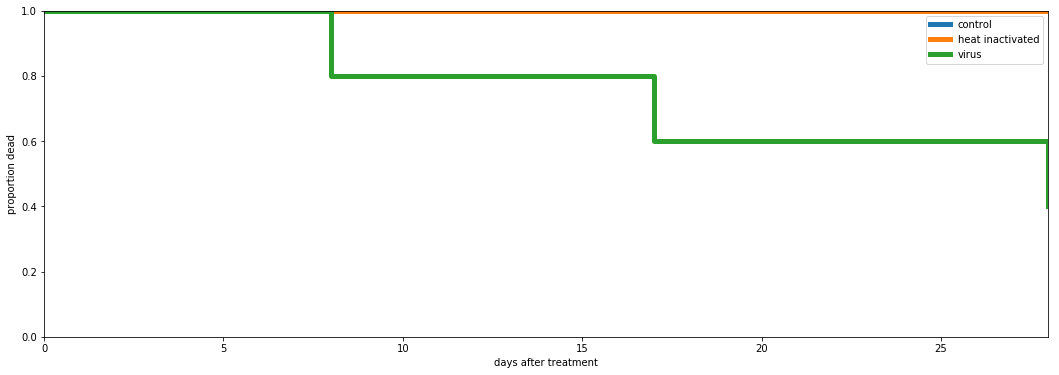

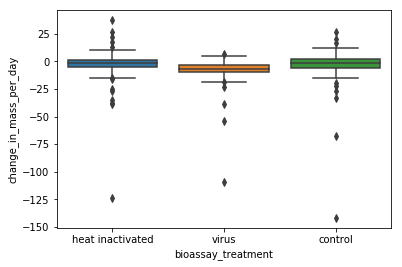

In [16]:
bioassay_names = [
    #'DUG42-%',
    #'MALB-%',
    #'MALBperOS-%',
    #'PNG-%',
    #'PNGperOS-%',
    #'V23B-%',
    #'V23B_large_bioassay-%',
    'V23B_perOSIN-%',
    #'V23BperOS-%'
]


for bioassay_name in bioassay_names:
    print('********** {}'.format(bioassay_name))
    notebook_version = 'v.2019-10-29'
    github_repo = 'https://github.com/aubreymoore/rearing3'

    title = bioassay_name.replace('-%', '')
    title = tex_escape(title)
    outputfile = 'bioassay-{}.pdf'.format(title)
    outputfile_url = '{}/raw/master/{}'.format(github_repo, outputfile)
    outputfile_url = outputfile_url.replace('\\_', '%5C_')

    path_to_postmortem_images = 'uploads'
    image_limit = 1000 # maximum number of post mortem images to include in report

    generate_pdf()